# WEAKLY SUPERVISED LOCALIZATION 
## USING CLASS ACTIVATION MAP 

In [1]:
import os
import numpy as np
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

# os.environ["CUDA_VISIBLE_DEVICES"]="2"
# from tensorflow.python.client import device_lib
# print device_lib.list_local_devices()

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
bus_adjacency: BUS_ANY
incarnation: 16279387810741875052
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11010776884
bus_adjacency: BUS_1
incarnation: 13636935545565225996
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:84:00.0"
]


In [2]:
# import urllib
# urllib.urlretrieve ("http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat",
#                     'imagenet-vgg-verydeep-19.mat')

# DEFINE FUNCTIONS

In [3]:
def imread(path):
    img = scipy.misc.imread(path).astype(np.float)
    if len(img.shape) == 2:
        img = np.transpose(np.array([img, img, img]), (2, 0, 1))
    return img
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)
def print_np(x, s):
    print ("Type of '%s' is %s" % (s, type(x)))
    print ("Shape of '%s' is %s" % (s, x.shape,))
    print ("dtype of '%s' is %s" % (s, x.dtype))

# LOAD CALTECH 101 DATA

In [4]:
cwd = os.getcwd()
path = cwd + "/data/101_ObjectCategories"
valid_exts = [".jpg", ".gif", ".png", ".jpeg"]
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path))
ncategories = len(categories)
nimgs = 0
for c in categories:
    nimgs += len([x for x in os.listdir(path+"/"+c) if os.path.splitext(x)[1] in valid_exts])
       
imgs = np.zeros((nimgs, 224, 224, 3), dtype=np.uint8)
labels = np.zeros((nimgs, ncategories), dtype=np.bool)
# LOAD ALL IMAGES 
idx = 0
for i, category in enumerate(categories):
    idx_prev = idx
    for f in os.listdir(path + "/" + category):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_exts:
            continue
        fullpath = os.path.join(path + "/" + category, f)
        img = scipy.misc.imresize(imread(fullpath), [224, 224, 3])
        imgs[idx, :, :, :] = img
        labels[idx, i] = 1
        idx += 1
    print ("%d/%d %d %s imgs are loaded" % (i+1, ncategories, idx-idx_prev, category))
print ("Num imgs: %d" % (imgs.shape[0]))
print ("Num labels: %d" % (labels.shape[0]) )

## DIVIDE THE DATASET INTO TWO

[101] CATEGORIES ARE IN 
 /home/chang/notebooks/tmp/../cam_vgg/data/101_ObjectCategories
1/101 435 Faces imgs are loaded
2/101 435 Faces_easy imgs are loaded
3/101 200 Leopards imgs are loaded
4/101 798 Motorbikes imgs are loaded
5/101 55 accordion imgs are loaded
6/101 800 airplanes imgs are loaded
7/101 42 anchor imgs are loaded
8/101 42 ant imgs are loaded
9/101 47 barrel imgs are loaded
10/101 54 bass imgs are loaded
11/101 46 beaver imgs are loaded
12/101 33 binocular imgs are loaded
13/101 128 bonsai imgs are loaded
14/101 98 brain imgs are loaded
15/101 43 brontosaurus imgs are loaded
16/101 85 buddha imgs are loaded
17/101 91 butterfly imgs are loaded
18/101 50 camera imgs are loaded
19/101 43 cannon imgs are loaded
20/101 123 car_side imgs are loaded
21/101 47 ceiling_fan imgs are loaded
22/101 59 cellphone imgs are loaded
23/101 62 chair imgs are loaded
24/101 107 chandelier imgs are loaded
25/101 47 cougar_body imgs are loaded
26/101 69 cougar_face imgs are loaded
27/101 73 

In [5]:
ndata = len(imgs)
ntrain = int(ndata*0.7) # WILL USE 70% FOR TRAINING
ntest = ndata-ntrain
randidx = np.random.permutation(ndata)
trainidx = randidx[:ntrain]
testidx = randidx[ntrain+1:]
train_imgs = imgs[trainidx, ...]
train_labels = labels[trainidx, ...]
test_imgs = imgs[testidx, ...]
test_labels = labels[testidx, ...]

# PLOT DATASET

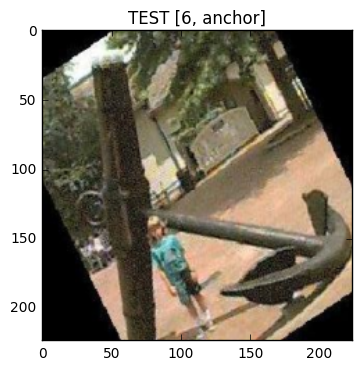

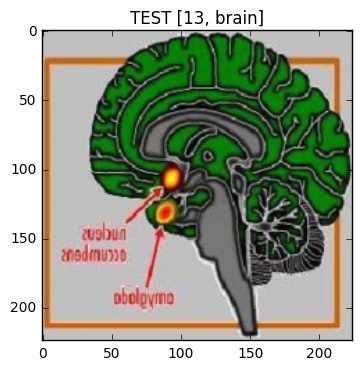

In [6]:
randidx = np.sort(np.random.randint(ntrain, size=2))
for i, j in enumerate(randidx):
    curr_img = train_imgs[j, :, :, :]
    curr_label = np.argmax(train_labels[j, :])
    plt.figure(i)
    plt.imshow(curr_img)
    plt.title("TRAIN [" + str(curr_label) + ", " + categories[curr_label] + "]")
    plt.draw()
randidx = np.sort(np.random.randint(ntest, size=2))
for i, j in enumerate(randidx):
    curr_img = test_imgs[j, :, :, :]
    curr_label = np.argmax(test_labels[j, :])
    plt.figure(i)
    plt.imshow(curr_img)
    plt.title("TEST [" + str(curr_label) + ", " + categories[curr_label] + "]")
    plt.draw()

# HELPER FUNCTIONS FOR USING VGG19

In [7]:
# FUNCTIONS FOR USING VGG19
def conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.bias_add(conv, bias)
def pool_layer(input):
    return tf.nn.max_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
def preprocess(image, mean_pixel):
    return image - mean_pixel
print "Functions for VGG ready"

# Define network
def vggnet(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )
    data = scipy.io.loadmat(data_path) # Read .mat file via scipy.io.loadmat
    # mean = data['normalization'][0][0][0]
    mean = data['meta'][0][0][2][0][0][2]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data['layers'][0]
    net = {}
    current = preprocess(input_image, mean_pixel)
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][2][0]
            # kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0 , 2, 3))
            bias = bias.reshape(-1)
            current = conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = pool_layer(current)
        net[name] = current
    assert len(net) == len(layers)
    return net, mean_pixel, layers
print ("Network for VGG ready")

Functions for VGG ready
Network for VGG ready


# LOAD PRETRAINED VGG19

In [8]:
cwd = os.getcwd()
VGG_PATH = cwd + "/imagenet-vgg-verydeep-19.mat"
img_placeholder = tf.placeholder('float', shape=(None, 224, 224, 3))
vgg, _, _ = vggnet(VGG_PATH, img_placeholder)    

# DEFINE GAP NETWORK

In [9]:
# PARAMETERS
n_output = ncategories
y = tf.placeholder('float', [None, n_output])
kr = tf.placeholder('float')
weights = {
    'out': tf.Variable(tf.random_normal([512, n_output], stddev=0.1))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output], stddev=0.01))
}
# NETWORK
def cam(_x, _W, _b, _kr):
    gap = tf.nn.avg_pool(_x, ksize=[1, 14, 14, 1], strides=[1, 14, 14, 1],
            padding='SAME')
    gap_dr = tf.nn.dropout(gap, _kr)
    gap_vec = tf.reshape(gap_dr, [-1, _W['out'].get_shape().as_list()[0]])
    out = tf.add(tf.matmul(gap_vec, _W['out']), _b['out'])
    ret = {'gap': gap, 'gap_dr': gap_dr, 'gap_vec': gap_vec, 'out': out}
    return ret
print ("NETWORK READY")

NETWORK READY


# DEFINE FUNCTIONS FOR THE NETWORK

In [10]:
pred = cam(vgg['relu5_4'], weights, biases, kr)['out']
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
corr = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accr = tf.reduce_mean(tf.cast(corr, 'float'))
init = tf.initialize_all_variables()
print ("FUNCTIONS READY")

FUNCTIONS READY


# TRAIN THE NETWRORK

In [11]:
# SOME PARAMETERS
training_epochs = 30
batch_size = 128
total_batch = (ntrain // batch_size) + 1
disp_step = 1

sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    avg_cost = 0.
    for i in range(total_batch):
        randidx = np.random.randint(ntrain, size=batch_size)
        batch_x = train_imgs[randidx, :, :, :]
        batch_y = train_labels[randidx, :]
        feeds_iter = {img_placeholder: batch_x, y: batch_y, kr: 0.7}
        _, c = sess.run([optm, cost], feed_dict=feeds_iter)
        avg_cost += c 
        # print (c)
    avg_cost = avg_cost / total_batch
    if epoch % disp_step == 0:
        feeds_train = {img_placeholder: batch_x, y: batch_y, kr: 1.}
        train_acc = sess.run(accr, feed_dict=feeds_train)
        test_idx = np.random.randint(len(test_imgs), size=100)
        test_imgs_temp = test_imgs[test_idx, :, :, :]
        test_labels_temp = test_labels[test_idx, :]
        feeds_test = {img_placeholder: test_imgs_temp, y: test_labels_temp, kr: 1.}
        test_acc = sess.run(accr, feed_dict=feeds_test)
        print ("[%d/%d] cost: %.4f train_acc: %.3f test_acc: %.3f" 
               % (epoch, training_epochs, avg_cost, train_acc, test_acc))
print ("OPTIMIZATION FINISHED")

[0/30] cost: 10.1635 train_acc: 0.312 test_acc: 0.260
[1/30] cost: 5.6376 train_acc: 0.500 test_acc: 0.470
[2/30] cost: 3.6714 train_acc: 0.648 test_acc: 0.600
[3/30] cost: 2.5318 train_acc: 0.719 test_acc: 0.670
[4/30] cost: 2.0450 train_acc: 0.805 test_acc: 0.740
[5/30] cost: 1.6382 train_acc: 0.820 test_acc: 0.730
[6/30] cost: 1.2795 train_acc: 0.844 test_acc: 0.780
[7/30] cost: 1.1299 train_acc: 0.922 test_acc: 0.820
[8/30] cost: 0.9724 train_acc: 0.891 test_acc: 0.860
[9/30] cost: 0.7892 train_acc: 0.891 test_acc: 0.810
[10/30] cost: 0.6999 train_acc: 0.922 test_acc: 0.880
[11/30] cost: 0.6320 train_acc: 0.969 test_acc: 0.830
[12/30] cost: 0.5471 train_acc: 0.953 test_acc: 0.710
[13/30] cost: 0.4999 train_acc: 0.961 test_acc: 0.810
[14/30] cost: 0.4608 train_acc: 0.961 test_acc: 0.780
[15/30] cost: 0.4181 train_acc: 0.969 test_acc: 0.850
[16/30] cost: 0.3760 train_acc: 0.984 test_acc: 0.820
[17/30] cost: 0.3311 train_acc: 0.977 test_acc: 0.890
[18/30] cost: 0.3178 train_acc: 0.977

Predicted : 86, starfish


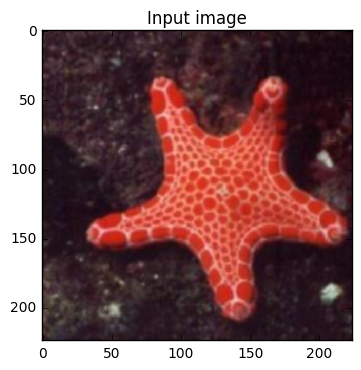

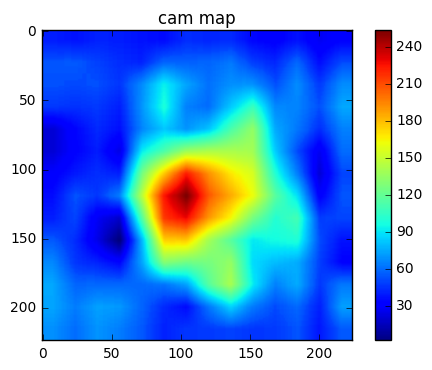

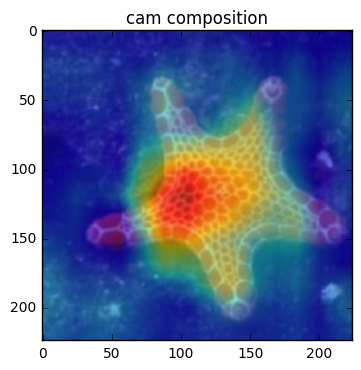

In [12]:
# Get Random Image
ntest = test_imgs.shape[0]
randidx = np.random.randint(ntest)
testimg = test_imgs[randidx, :, :, :]
testimg = testimg.reshape((-1,) + testimg.shape)

vgg, _, _ = vggnet(VGG_PATH, img_placeholder)
cam_testfeat, cam_outval, cam_weights = sess.run([vgg['relu5_4'], pred, weights['out']],
                                               feed_dict={img_placeholder: testimg, kr: 1.})
predlabel = np.argmax(cam_outval)
predweights = cam_weights[:, predlabel]
camsum = np.zeros((14, 14))
for i in xrange(512):
    camsum = camsum + predweights[i] * cam_testfeat[0,:,:,i]

camavg = scipy.misc.imresize(camsum / 256, [224, 224])

cm_jet = plt.get_cmap('jet')
camadd = camavg.copy().astype(np.float) - np.min(camavg)
camadd = camadd / np.max(camadd)
camadd = 0.5*testimg[0]/255. + 0.5*cm_jet(camadd)[..., :3]

print "Predicted : %d, %s" % (predlabel, categories[predlabel])
plt.figure(1)
plt.imshow(testimg[0])
plt.title("Input image")

plt.figure(2)
plt.imshow(camavg, cmap='jet')
# plt.matshow(camavg, cmap=plt.get_cmap('jet'))
plt.title("cam map")
plt.colorbar()
plt.draw()

plt.figure(3)
plt.imshow(camadd)
plt.title("cam composition")
plt.draw()